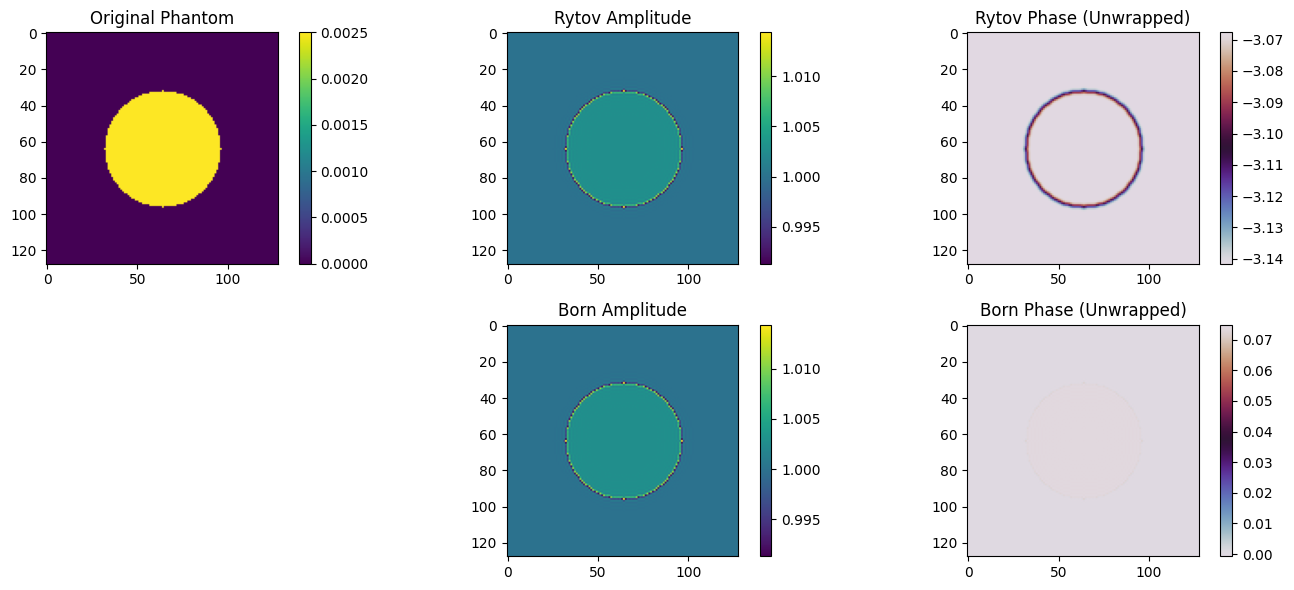

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter
from scipy.special import hankel1

# -----------------------------
# 2D Green's function
# -----------------------------
def green2d(R, k):
    g = np.zeros_like(R, dtype=np.complex128)
    mask = R != 0
    g[mask] = 1j/4 * hankel1(0, k*R[mask])
    g[~mask] = 1j/4 * hankel1(0, k*1e-10)
    return g

# -----------------------------
# Born 2D Fourier method
# -----------------------------
def born_2d_fourier(n, lD, nm, lambd, zeropad=True):
    km = 2*np.pi*nm/lambd
    f = km**2 * ((n/nm)**2 - 1)
    a0 = 1.0
    
    N = n.shape[0]
    if zeropad:
        order = int(2**np.ceil(np.log2(2*N)))
    else:
        order = N
    pads = order - N
    
    f_pad = np.pad(f, ((pads//2,pads//2),(pads//2,pads//2)), mode='constant')
    
    F = np.fft.fftshift(np.fft.fft2(f_pad))
    
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[0]))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[1]))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    kz = np.sqrt(np.maximum(km**2 - KX**2 - KY**2, 0)) - km
    
    with np.errstate(divide='ignore', invalid='ignore'):
        M = np.sqrt(np.maximum(km**2 - KX**2 - KY**2, 0))/km
        prefactor = 1j * a0 / km * np.sqrt(np.pi/2) / M * np.exp(1j*km*M*lD)
        prefactor[~np.isfinite(prefactor)] = 0.0
    
    U = F * prefactor
    uB_pad = np.fft.ifft2(np.fft.ifftshift(U))
    
    start = pads//2
    end = start + N
    uB = uB_pad[start:end, start:end]
    
    u = np.exp(1j*km*lD) + uB
    return u

# -----------------------------
# Rytov 2D (Bornscat style)
# -----------------------------
def rytov_2d(n, nm, lambd, lD=1.0, zeropad=True):
    km = 2*np.pi*nm/lambd
    f = km**2 * ((n/nm)**2 - 1)
    a0 = 1.0
    
    N = n.shape[0]
    if zeropad:
        order = int(2**np.ceil(np.log2(2*N)))
    else:
        order = N
    pads = order - N
    
    f_pad = np.pad(f, ((pads//2,pads//2),(pads//2,pads//2)), mode='constant')
    F = np.fft.fftshift(np.fft.fft2(f_pad))
    
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[0]))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(F.shape[1]))
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    M = np.sqrt(np.maximum(km**2 - KX**2 - KY**2, 0))/km
    with np.errstate(divide='ignore', invalid='ignore'):
        prefactor = 1j * a0 / km * np.sqrt(np.pi/2) / M * np.exp(1j*km*M*lD)
        prefactor[~np.isfinite(prefactor)] = 0.0
    
    U = F * prefactor
    uB_pad = np.fft.ifft2(np.fft.ifftshift(U))
    start = pads//2
    end = start + N
    uB = uB_pad[start:end, start:end]
    
    u = np.exp(1j*km*lD) + uB
    return u

# -----------------------------
# Phantom: 2D ellipsoid
# -----------------------------
N = 128
L = 80.0
px = L/N
x = np.linspace(-L/2, L/2 - px, N)
y = np.linspace(-L/2, L/2 - px, N)
X, Y = np.meshgrid(x, y, indexing='ij')

a, b = 20, 20
dn = 0.0025
phantom = np.zeros((N,N))
phantom[(X/a)**2 + (Y/b)**2 <= 1] = dn

# -----------------------------
# Compute fields
# -----------------------------
nm = 1.33
lambd = 0.532

u_rytov = rytov_2d(phantom + nm, nm, lambd)
u_born = born_2d_fourier(phantom + nm, lD=1.0, nm=nm, lambd=lambd)

# Phase relative to incident field for Born
km = 2*np.pi*nm/lambd
phase_born_rel = np.angle(u_born / np.exp(1j*km*1.0))

# Smooth Rytov field
u_smooth = gaussian_filter(np.real(u_rytov), 1) + 1j*gaussian_filter(np.imag(u_rytov), 1)
phase_rytov_unwrap = unwrap_phase(np.angle(u_smooth))

# Mask low amplitude regions
mask = np.abs(u_rytov) > 0.1
phase_rytov_unwrap[~mask] = 0
phase_born_unwrap = unwrap_phase(phase_born_rel)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(phantom, cmap='viridis')
plt.title('Original Phantom')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(np.abs(u_rytov), cmap='viridis')
plt.title('Rytov Amplitude')
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(phase_rytov_unwrap, cmap='twilight')
plt.title('Rytov Phase (Unwrapped)')
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(np.abs(u_born), cmap='viridis')
plt.title('Born Amplitude')
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(phase_born_unwrap, cmap='twilight')
plt.title('Born Phase (Unwrapped)')
plt.colorbar()

plt.tight_layout()
plt.show()


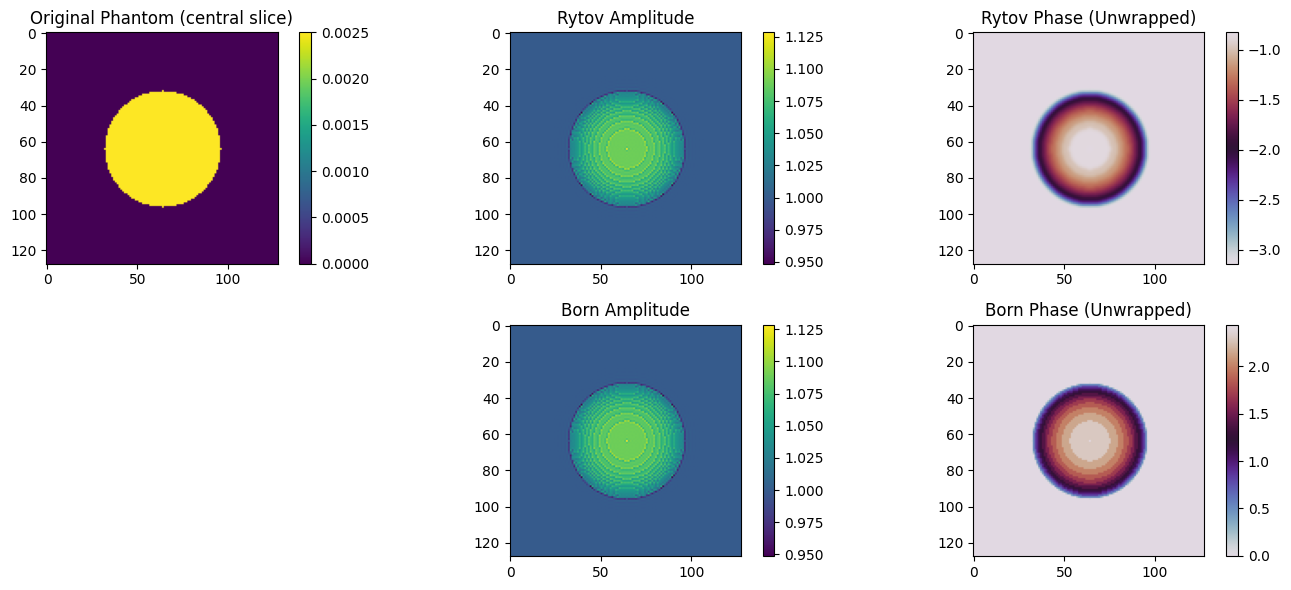

In [8]:
# -----------------------------
# 3D phantom: ellipsoid
# -----------------------------
N = 128
L = 80.0
px = L/N
x = np.linspace(-L/2, L/2 - px, N)
y = np.linspace(-L/2, L/2 - px, N)
z = np.linspace(-L/2, L/2 - px, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

a, b, c = 20, 20, 10  # ellipsoid axes
dn = 0.0025

phantom3d = np.zeros((N, N, N))
phantom3d[((X/a)**2 + (Y/b)**2 + (Z/c)**2) <= 1] = dn

# -----------------------------
# Multislice propagation
# -----------------------------
nm = 1.33
lambd = 0.532
dz = 1.0  # propagation distance per slice

u_born = np.exp(1j * 2*np.pi*nm/lambd * dz) * np.ones((N,N), dtype=np.complex128)
u_rytov = np.copy(u_born)

for k in range(N):
    slice_n = phantom3d[:, :, k] + nm
    # 2D propagation for each slice
    u_born = born_2d_fourier(slice_n, lD=dz, nm=nm, lambd=lambd) * u_born / np.exp(1j*2*np.pi*nm/lambd * dz)
    u_rytov = rytov_2d(slice_n, nm, lambd, lD=dz) * u_rytov / np.exp(1j*2*np.pi*nm/lambd * dz)

# -----------------------------
# Compute phase
# -----------------------------
phase_born_rel = np.angle(u_born / np.exp(1j*2*np.pi*nm/lambd * dz))
u_smooth = gaussian_filter(np.real(u_rytov), 1) + 1j*gaussian_filter(np.imag(u_rytov), 1)
phase_rytov_unwrap = unwrap_phase(np.angle(u_smooth))

mask = np.abs(u_rytov) > 0.1
phase_rytov_unwrap[~mask] = 0
phase_born_unwrap = unwrap_phase(phase_born_rel)

# -----------------------------
# Plot central slice
# -----------------------------
plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(phantom3d[:, :, N//2], cmap='viridis')
plt.title('Original Phantom (central slice)')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(np.abs(u_rytov), cmap='viridis')
plt.title('Rytov Amplitude')
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(phase_rytov_unwrap, cmap='twilight')
plt.title('Rytov Phase (Unwrapped)')
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(np.abs(u_born), cmap='viridis')
plt.title('Born Amplitude')
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(phase_born_unwrap, cmap='twilight')
plt.title('Born Phase (Unwrapped)')
plt.colorbar()

plt.tight_layout()
plt.show()


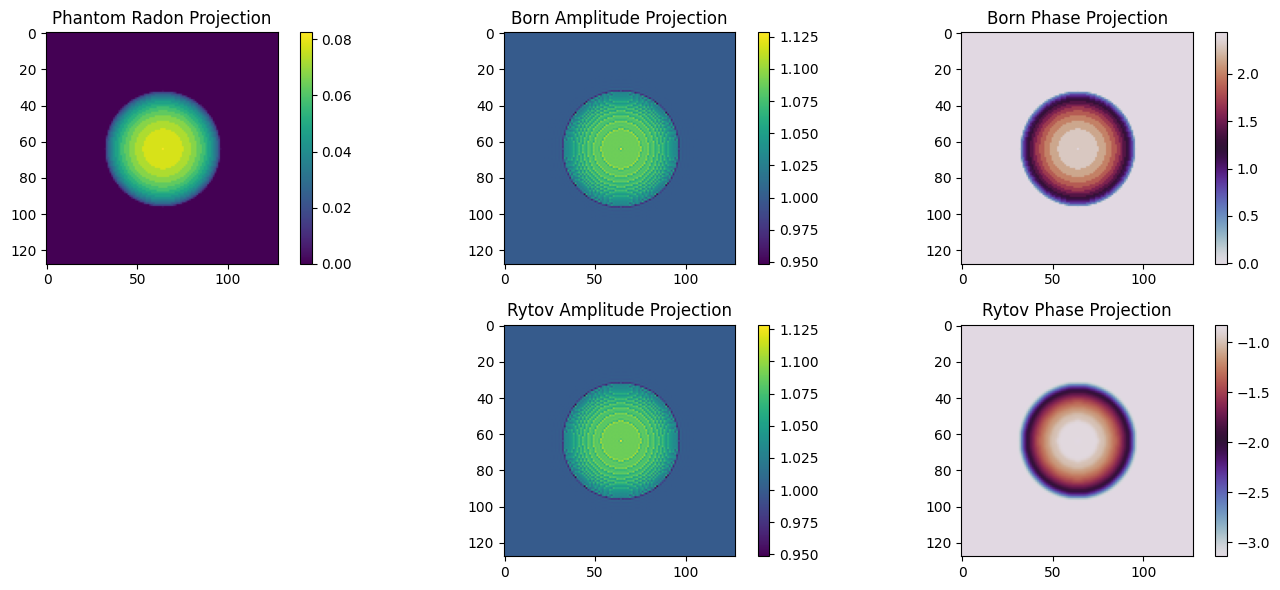

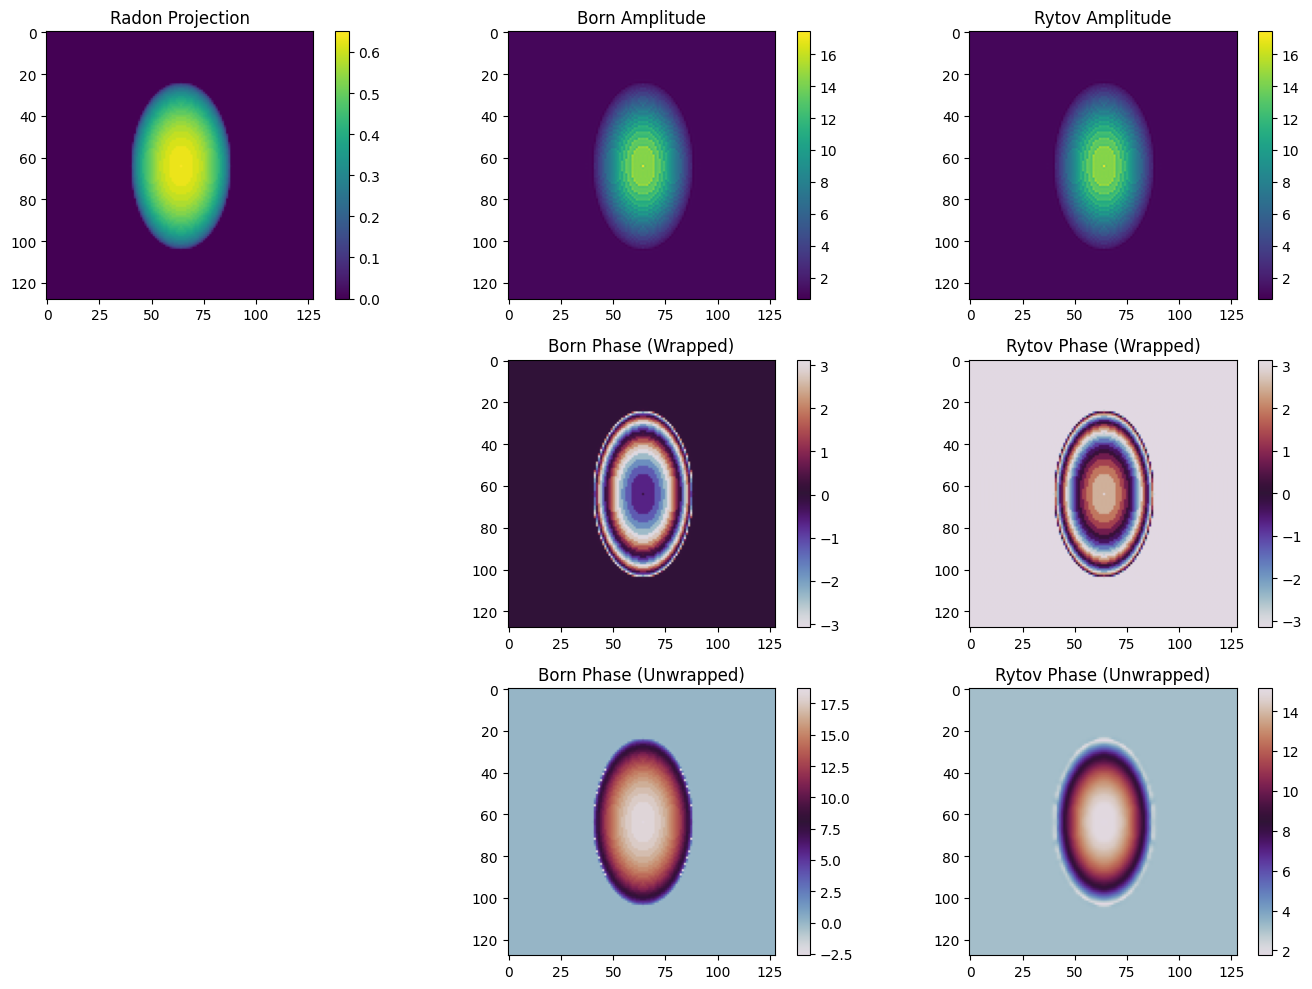

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter

# -----------------------------
# 3D phantom: ellipsoid
# -----------------------------
N = 128
L = 80.0
px = L/N
x = np.linspace(-L/2, L/2 - px, N)
y = np.linspace(-L/2, L/2 - px, N)
z = np.linspace(-L/2, L/2 - px, N)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

a, b, c = 25, 15, 20  # ellipsoid axes
dn = 0.01

phantom3d = np.zeros((N, N, N))
phantom3d[((X/a)**2 + (Y/b)**2 + (Z/c)**2) <= 1] = dn

# -----------------------------
# Multislice propagation
# -----------------------------
nm = 1.33
lambd = 0.532
dz = 1.0

u_born = np.exp(1j * 2*np.pi*nm/lambd * dz) * np.ones((N,N), dtype=np.complex128)
u_rytov = np.copy(u_born)

for k in range(N):
    slice_n = phantom3d[:, :, k] + nm
    u_born = born_2d_fourier(slice_n, lD=dz, nm=nm, lambd=lambd) * u_born / np.exp(1j*2*np.pi*nm/lambd * dz)
    u_rytov = rytov_2d(slice_n, nm, lambd, lD=dz) * u_rytov / np.exp(1j*2*np.pi*nm/lambd * dz)

# -----------------------------
# Compute Radon-style projection along z
# -----------------------------
radon_proj = np.sum(phantom3d, axis=2)

phase_born_rel = np.angle(u_born / np.exp(1j*2*np.pi*nm/lambd * dz))
mask_born = np.abs(u_born) > 0.1
phase_born_rel[~mask_born] = 0
phase_born_unwrap = unwrap_phase(phase_born_rel)

u_rytov_smooth = gaussian_filter(np.real(u_rytov), 1) + 1j*gaussian_filter(np.imag(u_rytov), 1)
phase_rytov_unwrap = unwrap_phase(np.angle(u_rytov_smooth))
mask_rytov = np.abs(u_rytov) > 0.1
phase_rytov_unwrap[~mask_rytov] = 0

# -----------------------------
# Plot Radon + amplitude + phase
# -----------------------------
plt.figure(figsize=(14,10))

# Row 1: Radon projection
plt.subplot(3,3,1)
plt.imshow(radon_proj, cmap='viridis')
plt.title('Radon Projection')
plt.colorbar()

plt.subplot(3,3,2)
plt.imshow(np.abs(u_born), cmap='viridis')
plt.title('Born Amplitude')
plt.colorbar()

plt.subplot(3,3,3)
plt.imshow(np.abs(u_rytov), cmap='viridis')
plt.title('Rytov Amplitude')
plt.colorbar()

# Row 2: Wrapped phase
plt.subplot(3,3,5)
plt.imshow(phase_born_rel, cmap='twilight')
plt.title('Born Phase (Wrapped)')
plt.colorbar()

plt.subplot(3,3,6)
plt.imshow(np.angle(u_rytov), cmap='twilight')
plt.title('Rytov Phase (Wrapped)')
plt.colorbar()

# Row 3: Unwrapped phase
plt.subplot(3,3,8)
plt.imshow(phase_born_unwrap, cmap='twilight')
plt.title('Born Phase (Unwrapped)')
plt.colorbar()

plt.subplot(3,3,9)
plt.imshow(phase_rytov_unwrap, cmap='twilight')
plt.title('Rytov Phase (Unwrapped)')
plt.colorbar()

plt.tight_layout()
plt.show()
